# Remote Execution Demo

### Import Local Modules

In [10]:
import argparse
from client_api.rexec import remote_exec

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

### Remote Function Defination

In [11]:
@remote_exec
def rfunc():
    import s3fs
    import numpy as np
    from netCDF4 import Dataset
    import matplotlib.pyplot as plt
    
    s3 = s3fs.S3FileSystem(anon=True)

    s3files = s3.ls("s3://noaa-goes17/ABI-L1b-RadC/2020/009/18/")
    s3file = None
    for f in s3files:
        if f.startswith("noaa-goes17/ABI-L1b-RadC/2020/009/18/OR_ABI-L1b-RadC-M6C03"):
            s3file = f
            break
    s3.get(f, "test.nc")
    data = Dataset("test.nc")
    array = data["Rad"]

    lb = (0, 2500)
    ub = (1499, 4999)
    index = [ slice(lb[x], ub[x]+1) for x in range(len(lb)) ]

    radiance = array[index]

    # Define some constants needed for the conversion. From the pdf linked above
    Esun_Ch_01 = 726.721072
    Esun_Ch_02 = 663.274497
    Esun_Ch_03 = 441.868715
    d2 = 0.3
    # Apply the formula to convert radiance to reflectance
    ref = (radiance * np.pi * d2) / Esun_Ch_02

    # Make sure all data is in the valid data range
    ref = np.maximum(ref, 0.0)
    ref = np.minimum(ref, 1.0)

    # Apply the formula to adjust reflectance gamma
    ref_gamma = np.sqrt(ref)

    fig, axs = plt.subplots()

    im = axs.imshow(ref_gamma, vmin=0.0, vmax=1.0, cmap='Greys_r')
    cb = plt.colorbar(im, orientation='horizontal')
    cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    cb.set_label('Reflectance')
    plt.savefig("test.png")

    image = plt.imread("test.png")

    return image

In [12]:
@remote_exec
def rexec_string_add_test(string_list):

    rtrn_str = "Object key strings given: ["

    # Create a single string out of the string list
    i = 1
    for key in string_list:
        if i == len(string_list):
            rtrn_str += f"{str(key)}]"
        else:
            rtrn_str += f"{str(key)}, "
        i +=1 

    return rtrn_str

### Local Function Defination

In [13]:
def lfunc():
    import s3fs
    import numpy as np
    from netCDF4 import Dataset
    import matplotlib.pyplot as plt
    
    s3 = s3fs.S3FileSystem(anon=True)

    s3files = s3.ls("s3://noaa-goes17/ABI-L1b-RadC/2020/009/18/")
    s3file = None
    for f in s3files:
        if f.startswith("noaa-goes17/ABI-L1b-RadC/2020/009/18/OR_ABI-L1b-RadC-M6C03"):
            s3file = f
            break
    s3.get(f, "test.nc")
    data = Dataset("test.nc")
    array = data["Rad"]

    lb = (0, 2500)
    ub = (1499, 4999)
    index = [ slice(lb[x], ub[x]+1) for x in range(len(lb)) ]

    radiance = array[index]

    # Define some constants needed for the conversion. From the pdf linked above
    Esun_Ch_01 = 726.721072
    Esun_Ch_02 = 663.274497
    Esun_Ch_03 = 441.868715
    d2 = 0.3
    # Apply the formula to convert radiance to reflectance
    ref = (radiance * np.pi * d2) / Esun_Ch_02

    # Make sure all data is in the valid data range
    ref = np.maximum(ref, 0.0)
    ref = np.minimum(ref, 1.0)

    # Apply the formula to adjust reflectance gamma
    ref_gamma = np.sqrt(ref)

    fig, axs = plt.subplots()

    im = axs.imshow(ref_gamma, vmin=0.0, vmax=1.0, cmap='Greys_r')
    cb = plt.colorbar(im, orientation='horizontal')
    cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    cb.set_label('Reflectance')
    plt.savefig("test.png")

    image = plt.imread("test.png")


    return image

### Main Function

Remote Exec time is 11.160205162999773 second.


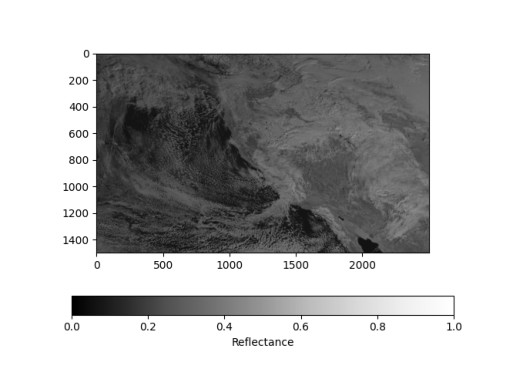

Local Exec time is 8.070879374001379 second.
Object key strings given: [aaa, bbb, ccc]


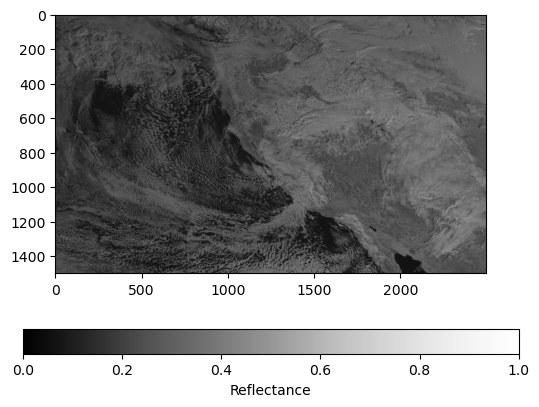

In [14]:
remote_exec().set_remote_addr("ip-10-244-2-237.chpc.utah.edu")
remote_exec().set_remote_port("5559")

start = time.perf_counter()
image = rfunc()
end = time.perf_counter()
print(f"Remote Exec time is {end-start} second.")

plt.imshow(image)
plt.axis('off')
plt.show()

start = time.perf_counter()
limage = lfunc()
end = time.perf_counter()
print(f"Local Exec time is {end-start} second.")

str_ls = ["aaa", "bbb", "ccc"]
print(rexec_string_add_test(str_ls))